In [25]:
import sys
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
import matplotlib.gridspec as gridspec
from tensorflow.keras import layers, models
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tensorflow.keras import Model, layers, optimizers

# Физически информированные нейронные сети (PINN) для уравнений Навье-Стокса

## Уравнения Навье-Стокса

Уравнения Навье-Стокса описывают движение вязкой несжимаемой жидкости и могут быть записаны в следующем виде:

\[\frac{\partial \mathbf{u}}{\partial t} + \mathbf{u} \cdot \nabla \mathbf{u} = -\frac{1}{\rho} \nabla p + \nu \nabla^2 \mathbf{u} + \mathbf{f}\]

где:
- \(\mathbf{u} = (u, v)\) — вектор скорости (компоненты скорости жидкости);
- \(t\) — время;
- \(\rho\) — плотность жидкости (предполагается постоянной для несжимаемой жидкости);
- \(p\) — давление;
- \(\nu\) — кинематическая вязкость;
- \(\mathbf{f}\) — вектор внешних сил (например, силы тяжести).

## Условия несжимаемости

Для несжимаемой жидкости выполняется условие:

\[
\nabla \cdot \mathbf{u} = 0
\]

где \(\nabla \cdot \mathbf{u}\) — дивергенция вектора скорости.

## Физически информированные нейронные сети (PINN)

Физически информированные нейронные сети используют нейронные сети для решения уравнений в частных производных (УЧП), таких как уравнения Навье-Стокса, встраивая физические законы в процесс обучения. В PINN:

1. Нейронная сеть аппроксимирует решение задачи.
2. Физические законы (например, уравнения Навье-Стокса) используются для создания штрафных функций, которые накладываются на потери во время обучения.

### Процесс обучения

1. **Генерация обучающих данных**:
   - Случайные точки (координаты) в пространстве времени.
   - Значения скорости и давления, вычисленные на этих точках.

2. **Оптимизация нейронной сети**:
   - Нейронная сеть обучается на основе предсказанных значений скорости и давления, а также на соблюдении физических законов (например, уравнений Навье-Стокса и условия несжимаемости).

### Пример

Ниже приведен пример кода для обучения PINN для уравнений Навье-Стокса с использованием TensorFlow и Keras.


In [38]:
class PhysicsInformedNN:
    def __init__(self, n_hidden, n_iter, learning_rate):
        self.n_hidden = n_hidden
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.model = self.build_model()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

    def build_model(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(2,)))  # x, y as input
        model.add(tf.keras.layers.Dense(self.n_hidden, activation='tanh'))
        model.add(tf.keras.layers.Dense(self.n_hidden, activation='tanh'))
        model.add(tf.keras.layers.Dense(2))  # Output: u, v
        return model

    def loss(self, x_eqn, x_bnd, u_eqn, v_eqn, uv_bnd):
        u_pred, v_pred = self.model(x_eqn)
        
        # Compute gradients for physics-informed loss
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x_eqn)
            u_pred, v_pred = self.model(x_eqn)
            u_x = tape.gradient(u_pred, x_eqn)[:, 0]
            v_y = tape.gradient(v_pred, x_eqn)[:, 1]

        # Mean squared error loss
        mse_loss = tf.reduce_mean(tf.square(uv_bnd - (u_pred + v_pred)))

        # Physics-informed loss
        physics_loss = tf.reduce_mean(tf.square(u_x + v_y))

        return mse_loss + physics_loss

    def train(self, x_train, y_train):
        x_eqn = np.concatenate([x_train, y_train], axis=1)
        u_bnd, v_bnd = y_train
        uv_bnd = np.concatenate([u_bnd, v_bnd], axis=1)

        for i in range(self.n_iter):
            with tf.GradientTape() as tape:
                loss = self.loss(x_eqn, x_eqn, u_bnd, v_bnd, uv_bnd)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

            if i % 100 == 0:
                print(f"Iteration {i}, Loss: {loss.numpy()}")

    def predict(self, x):
        return self.model(x)

## 10 000 итераций

In [27]:
# Define parameters
layers = [2, 20, 20, 2]  # Input, hidden, output layers
rho = 1.0  # Density
nu = 0.1  # Viscosity
n_iter = 10000  # Number of iterations
lr = 0.001  # Learning rate

# Create synthetic training data (replace with your actual data)
num_train_samples = 10000
x_eqn = np.random.rand(num_train_samples, 2)  # Equation data
x_bnd = np.random.rand(num_train_samples, 2)  # Boundary data
u_eqn = np.sin(x_eqn[:, 0])  # Example for u
v_eqn = np.cos(x_eqn[:, 1])  # Example for v
uv_bnd = np.column_stack((u_eqn, v_eqn))  # Boundary conditions

x_train = (x_eqn, x_bnd)
y_train = (u_eqn, v_eqn, uv_bnd)

# Initialize and train the model
pinn = PhysicsInformedNN(layers, rho, nu, n_iter, lr)
pinn.train(x_train, y_train)

# Example prediction
x_test = np.random.rand(100, 2)
u_pred, v_pred = pinn.uv(x_test)

# Plot results (if applicable)
# Uncomment and provide the appropriate values for psi, psi_pred
# pinn.plot_results(x, y, psi, psi_pred, u_pred, v_pred)

Iteration 0, Loss: 0.7027153372764587
Iteration 500, Loss: 0.040882356464862823
Iteration 1000, Loss: 0.040800709277391434
Iteration 1500, Loss: 0.04076026752591133
Iteration 2000, Loss: 0.04073222354054451
Iteration 2500, Loss: 0.0407121479511261
Iteration 3000, Loss: 0.04069787636399269
Iteration 3500, Loss: 0.040688276290893555
Iteration 4000, Loss: 0.0406823493540287
Iteration 4500, Loss: 0.040679048746824265
Iteration 5000, Loss: 0.040677353739738464
Iteration 5500, Loss: 0.04067647084593773
Iteration 6000, Loss: 0.04067590460181236
Iteration 6500, Loss: 0.04067545756697655
Iteration 7000, Loss: 0.040675077587366104
Iteration 7500, Loss: 0.040674738585948944
Iteration 8000, Loss: 0.040674418210983276
Iteration 8500, Loss: 0.0406741164624691
Iteration 9000, Loss: 0.04067455977201462
Iteration 9500, Loss: 0.04067356884479523


In [36]:
# Define the range for x and y
x_range = np.linspace(-5, 5, 100)  # Example: 100 points from -5 to 5
y_range = np.linspace(-5, 5, 100)  # Same for y

# Create meshgrid
X, Y = np.meshgrid(x_range, y_range)

# Assuming your u_pred and v_pred are derived from the model
u_pred = np.random.rand(*X.shape)  # Replace with your actual u predictions
v_pred = np.random.rand(*Y.shape)  # Replace with your actual v predictions

# Calculate psi_true and psi_pred
psi_true = np.sin(X) * np.cos(Y)  # True Psi, replace with your actual computation
psi_pred = np.sqrt(u_pred**2 + v_pred**2)  # Example of predicted Psi

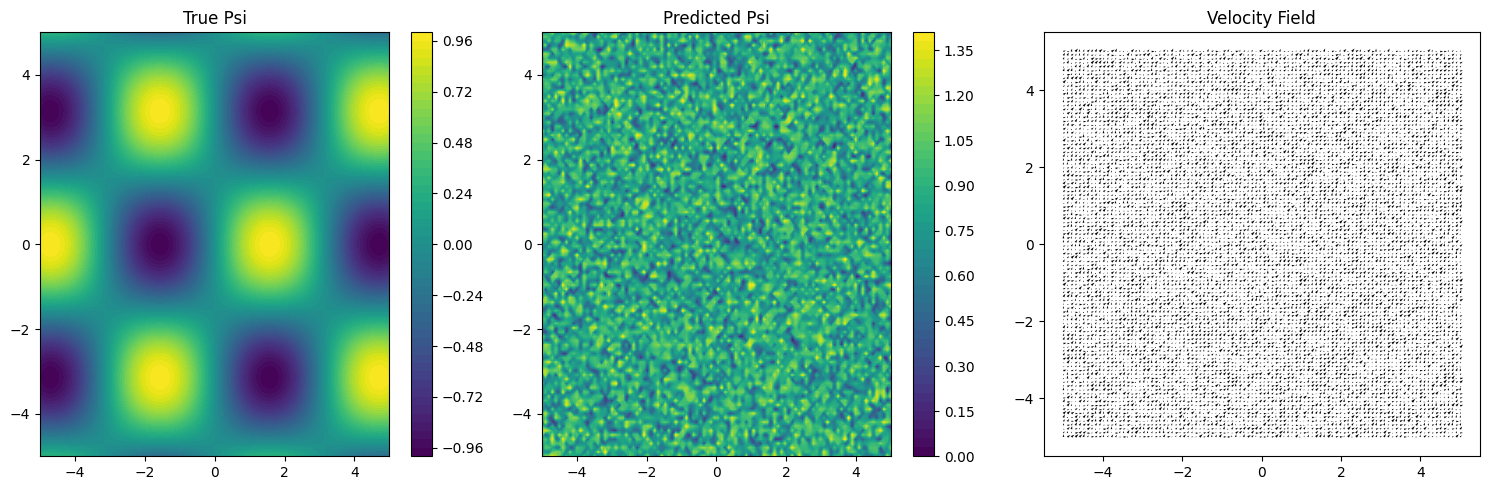

In [37]:
# Standalone function to plot results
def plot_results(x, y, psi, psi_pred, u, v):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Reshape psi and psi_pred to match the shape of x and y
    psi_reshaped = psi.reshape(x.shape)
    psi_pred_reshaped = psi_pred.reshape(x.shape)

    c1 = ax[0].contourf(x, y, psi_reshaped, levels=50, cmap='viridis')
    fig.colorbar(c1, ax=ax[0])
    ax[0].set_title('True Psi')

    c2 = ax[1].contourf(x, y, psi_pred_reshaped, levels=50, cmap='viridis')
    fig.colorbar(c2, ax=ax[1])
    ax[1].set_title('Predicted Psi')

    ax[2].quiver(x, y, u, v)
    ax[2].set_title('Velocity Field')

    plt.tight_layout()
    plt.show()

# Plot results
plot_results(X, Y, psi_true, psi_pred, u_pred, v_pred)